In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
from script import eval

In [2]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    out_lb = nn_layer_out_bounds[-1][0]
    out_ub = nn_layer_out_bounds[-1][1]
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    difference_lb.pop(label)
    difference_ub.pop(label)
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)

    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)


In [3]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [4]:
def get_output_vars_snv_milp(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("affine_var{}[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [5]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [6]:
def optimize_model(model, output_vars):
    start = time.time()
    model.update()
    model.optimize()
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        if max_var < 0:
            print("property verified with max difference {}".format(max_var))
            return True
        else:
             print("property NOT verified with max difference {}".format(max_var))
             return False

    elif model.Status == grp.GRB.INFEASIBLE:
        print("model infeasible")

        model.computeIIS()
        print("constraint")
        all_constr = model.getConstrs()

        for const in all_constr:
            if const.IISConstr:
                print("{}".format(const))

        print("lower bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISLB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

        print("upper bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISUB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

    print("time to optimize: {}".format(time.time() - start))
    return False

In [7]:
transform = Compose([ToTensor(),  Normalize(0.5, 0.5)])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device('cpu')), strict=False)

"""nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc_6x256.pth", map_location=torch.device('cpu')), strict=False)"""


parameter_list = list(nn.parameters())

output_size = 10
number_layer = (len(parameter_list) - 2) // 2

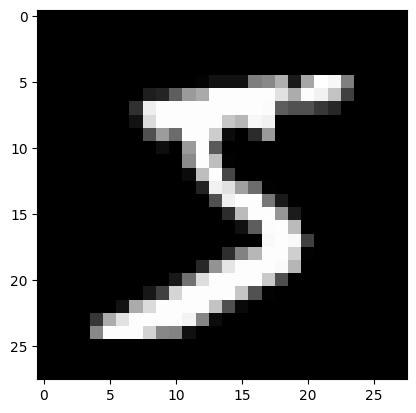

5
tensor([ -5.2223,  -4.9188,  -6.6589,   2.6449, -18.6182,   3.6405,  -9.5669,
         -4.3524, -10.9687,  -9.1357], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 6.4550,  7.2957,  7.8522, 15.6069, -5.7168, 17.2791,  2.3780,  8.4534,
         3.7083,  4.3367], dtype=torch.float64, grad_fn=<AddBackward0>)
nn classifies image correct as 5


In [8]:
image_index = 0
eps = 0.01
use_milp = True

image, label = training_data.__getitem__(image_index)
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(label)

input_flattened = torch.flatten(torch_image)
simple_bounds_affine_out, simple_bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(simple_bounds_affine_out[-1][0])
print(simple_bounds_affine_out[-1][1])

if torch.argmax(nn(torch_image)).item() == label:
    print("nn classifies image correct as {}".format(label))
else:
    print("nn classifies image wrong")

In [9]:
snv_verifier = SingleNeuronVerifier(nn, torch_image, eps, print_log=False, print_new_bounds=False, optimize_bounds=True)
snv_verifier.generate_constraints_for_net()
snv_model = snv_verifier.model
snv_model.update()
snv_out_vars = get_output_vars_snv_milp(snv_model, output_size, number_layer * 2)
add_output_constraints(snv_model, simple_bounds_layer_out, label, snv_out_vars)
print("start with optimization")
optimize_model(snv_model, snv_out_vars)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-12
start with optimization
var 0: 0.4858494753598763
var 1: 1.4649517324045447
var 2: 0.9155432086920279
var 3: 9.802351626573772
var 4: -12.851107872437726
var 5: 10.271969404639426
var 6: -3.7644485939576646
var 7: 2.483308645936438
var 8: -3.926853505445062
var 9: -2.370342753212388
property verified with max difference -0.4696177780656541


True

In [10]:
if use_milp:
    milp_verifier = MILPVerifier(nn, torch_image, eps, print_log=False)
    milp_verifier.generate_constraints_for_net()
    milp_model = milp_verifier.model
    milp_model.update()
    milp_out_vars = get_output_vars_snv_milp(milp_model, output_size, number_layer * 2)
    add_output_constraints(milp_model, simple_bounds_layer_out, label, milp_out_vars)
    print("start with optimization")
    optimize_model(milp_model, milp_out_vars)

start with optimization
var 0: 0.4885708783613403
var 1: 1.4636106054846554
var 2: 0.9076956650431267
var 3: 9.788965524468788
var 4: -12.850973191498886
var 5: 10.304151683287818
var 6: -3.7567780542749656
var 7: 2.4711471014766424
var 8: -3.922207491256568
var 9: -2.3915604795125223
property verified with max difference -0.5151861588190302


In [14]:
group_size = 2
"""icnn_factory = ICNNFactory("logical", [10, 5, 1], force_positive_init=False, with_two_layers=False,
                           init_scaling=10, init_all_with_zeros=False)"""
icnn_factory = ICNNFactory("standard", [5, 1])
# icnn_factory = ICNNFactory("approx_max", [5, 1], maximum_function="SMU", function_parameter=0.3)

dhov_verifier = multidhov.MultiDHOV()
dhov_verifier.start_verification(nn, torch_image, icnn_factory, group_size, eps=eps, icnn_epochs=1,
                                 icnn_batch_size=1000, sample_count=100, sample_new=False, use_over_approximation=True, break_after=None,
                                 sample_over_input_space=False, sample_over_output_space=True, use_icnn_bounds=True,
                                 use_fixed_neurons=True, sampling_method="per_group_sampling",
                                 force_inclusion_steps=5, preemptive_stop=False, even_gradient_training=False,
                                 keep_ambient_space=True, data_grad_descent_steps=0, opt_steps_gd=200,
                                 train_outer=False, print_training_loss=False, print_new_bounds=False,
                                 grouping_method="consecutive", group_num_multiplier=5, store_samples=True, print_optimization_steps=False,
                                 should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included")


approximation of layer: 0
    number of fixed neurons for current layer: 92
    layer progress, group 1 of 4 
        time for sampling for one group: 0.0
        time for training: 0.01561737060546875
        actual verification time 0.015635013580322266
        time for verification: 0.08466911315917969
    layer progress, group 2 of 4 
        time for sampling for one group: 0.0
        time for training: 0.015628337860107422
        actual verification time 0.020172119140625
        time for verification: 0.1150655746459961
    layer progress, group 3 of 4 
        time for sampling for one group: 0.008041143417358398
        time for training: 0.010128259658813477
        actual verification time 0.020343303680419922
        time for verification: 0.1111905574798584
    layer progress, group 4 of 4 
        time for sampling for one group: 0.0
        time for training: 0.01211237907409668
        actual verification time 0.02018904685974121
        time for verification: 0.0913

In [12]:
print(dhov_verifier.all_group_indices)

[[[1, 23], [25, 51], [60, 69], [86, 96]], [[0]]]


In [13]:
print(dhov_verifier.bounds_affine_out[-1][0])
print(dhov_verifier.bounds_affine_out[-1][1])

tensor([  0.0781,   0.9490,  -0.4034,   8.6226, -13.4046,  10.0950,  -3.9682,
          1.5782,  -4.3153,  -2.9866], dtype=torch.float64,
       grad_fn=<CopySlices>)
tensor([  1.0446,   1.9062,   1.2920,   9.9319, -12.0511,  11.2635,  -2.9573,
          2.7405,  -3.1273,  -1.7695], dtype=torch.float64,
       grad_fn=<CopySlices>)


In [14]:
dhov_model = dhov_verifier.nn_encoding_model.copy()
dhov_model.update()
dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)

In [15]:
add_output_constraints(dhov_model, simple_bounds_layer_out, label, dhov_out_vars)

In [16]:
optimize_model(dhov_model, dhov_out_vars)

var 0: -3.252652207994199
var 1: 1.741214824107443
var 2: -1.3607030902431152
var 3: 0.7242158346068965
var 4: -2.072284323321309
var 5: 0.9447702901665114
var 6: -5.752782504507449
var 7: 3.82050436954699
var 8: -0.4693440238119333
var 9: 4.302116786674258
property NOT verified with max difference 0.481612417127268


False

Current layer 0, current group tensor([0, 4])


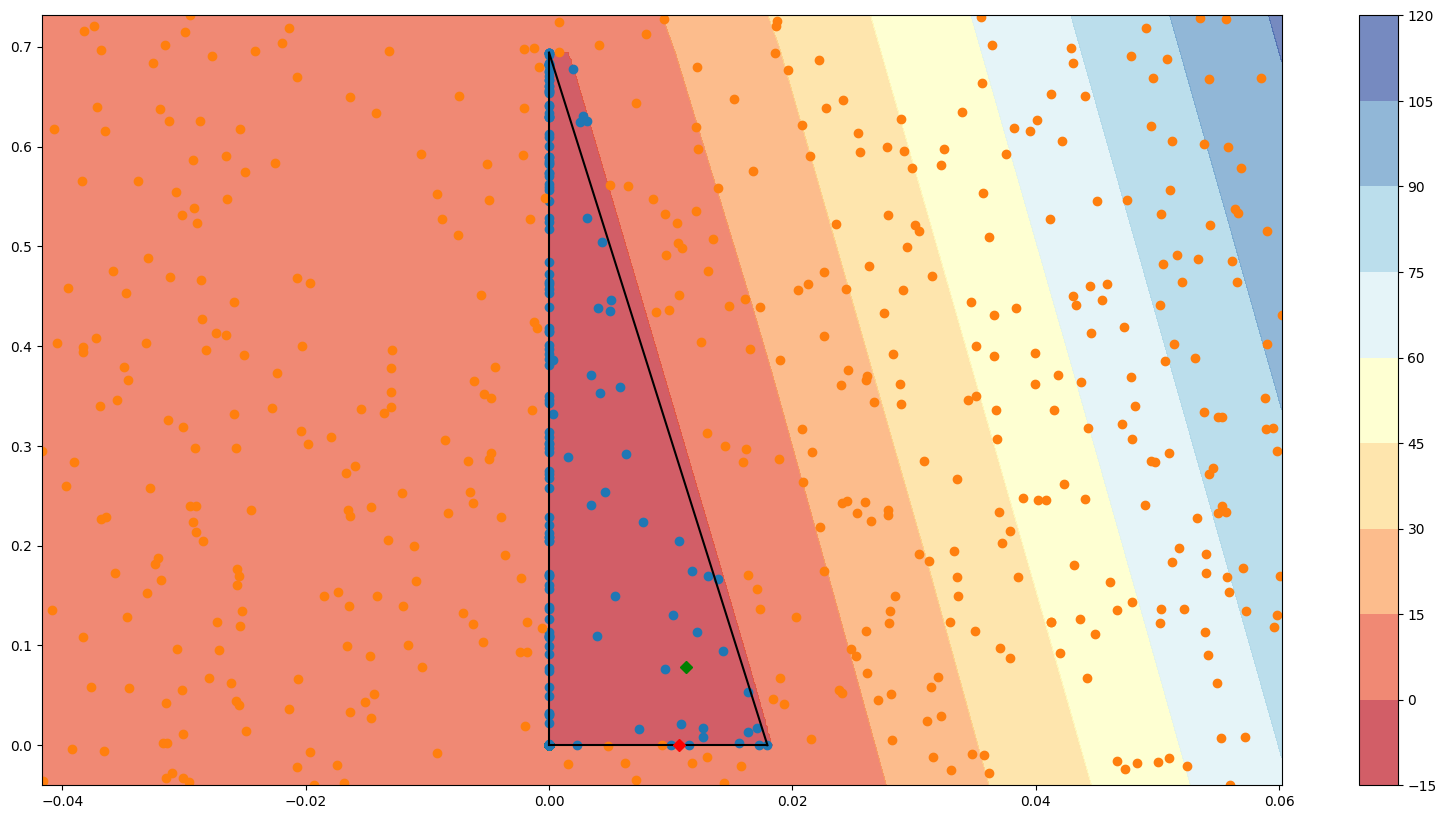

Current layer 0, current group tensor([ 9, 11])


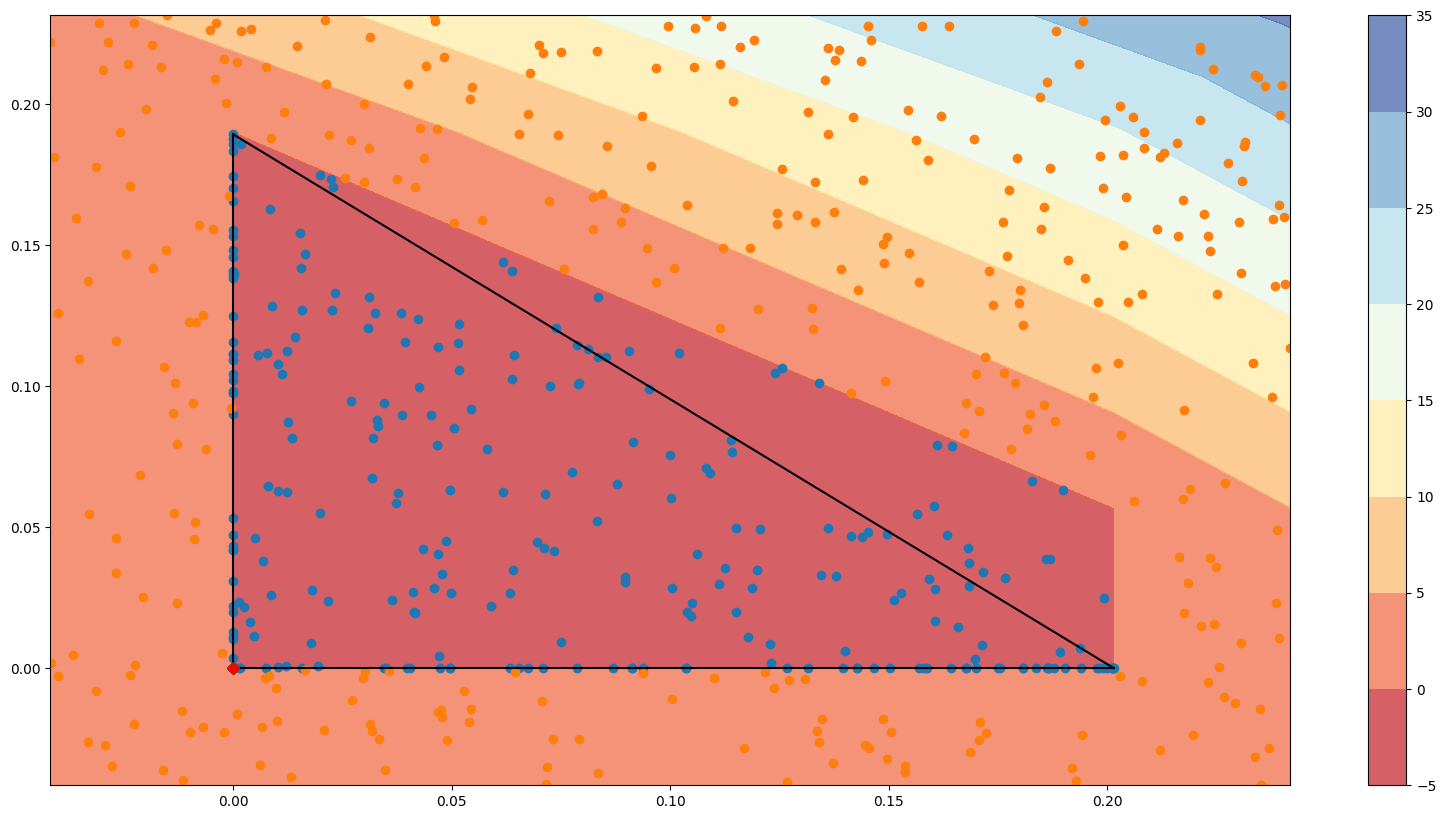

Current layer 0, current group tensor([12, 16])


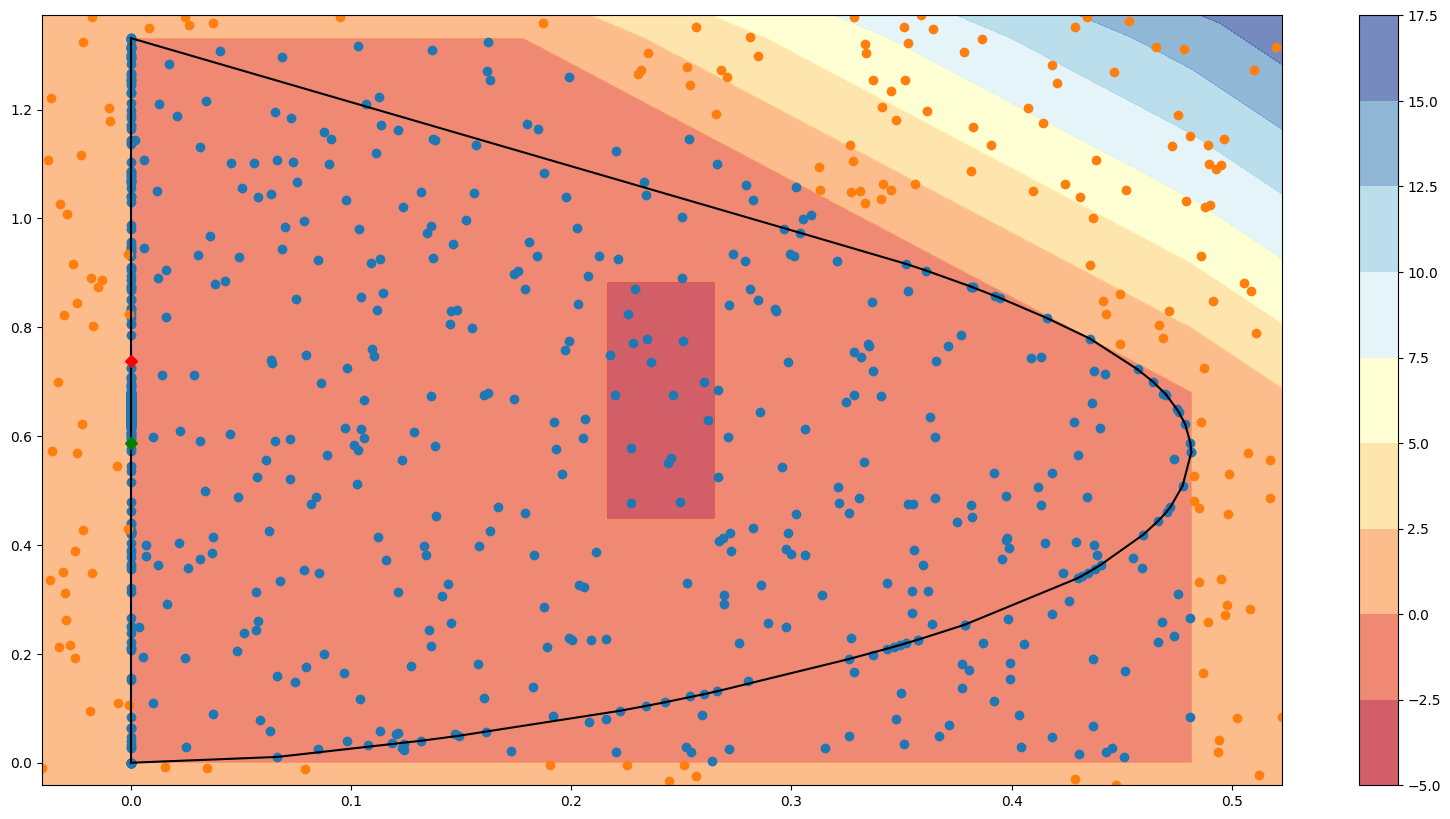

Current layer 0, current group tensor([18, 20])


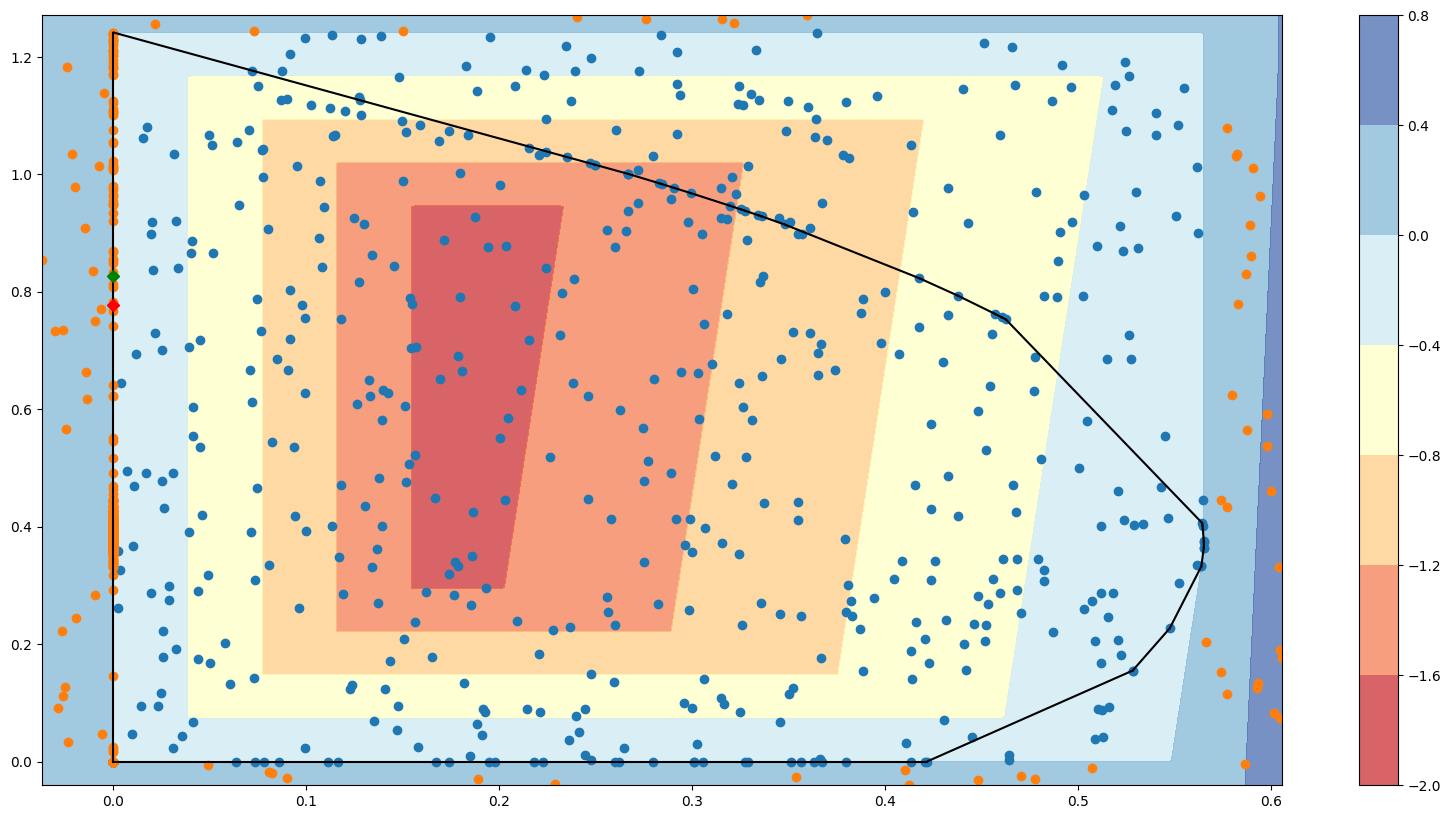

Current layer 0, current group tensor([21, 22])


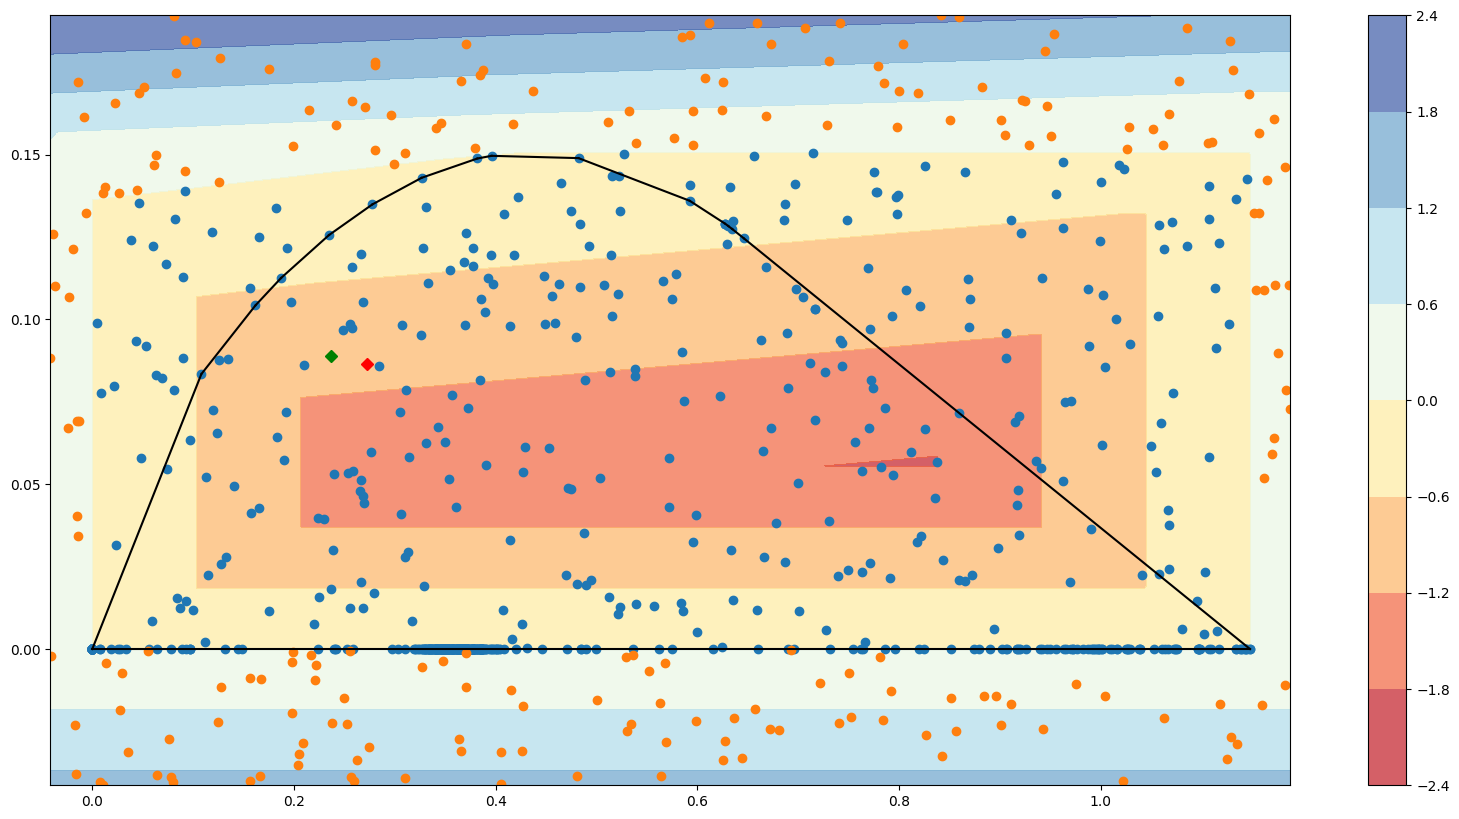

Current layer 0, current group tensor([24, 26])


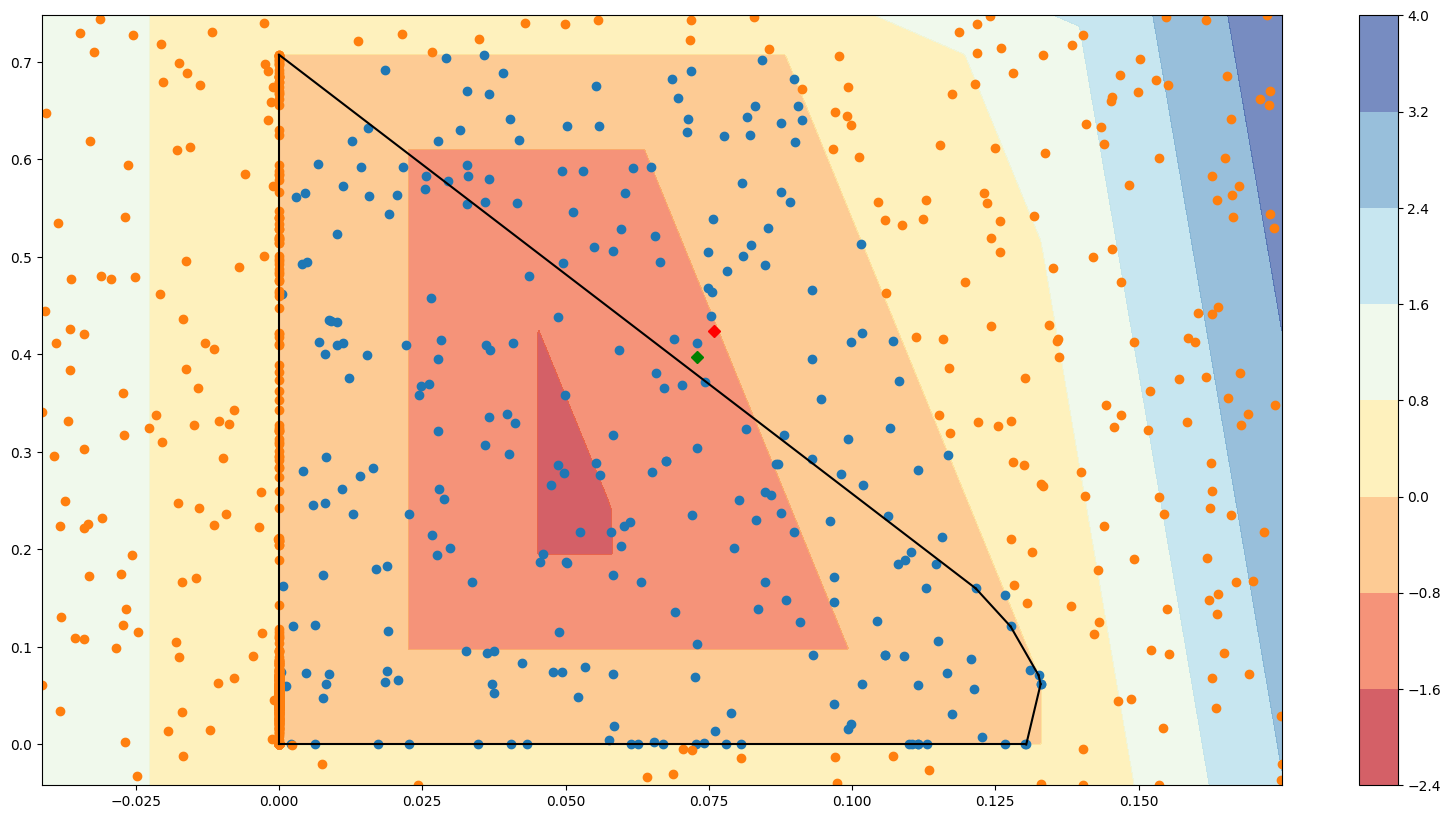

Current layer 0, current group tensor([31, 32])


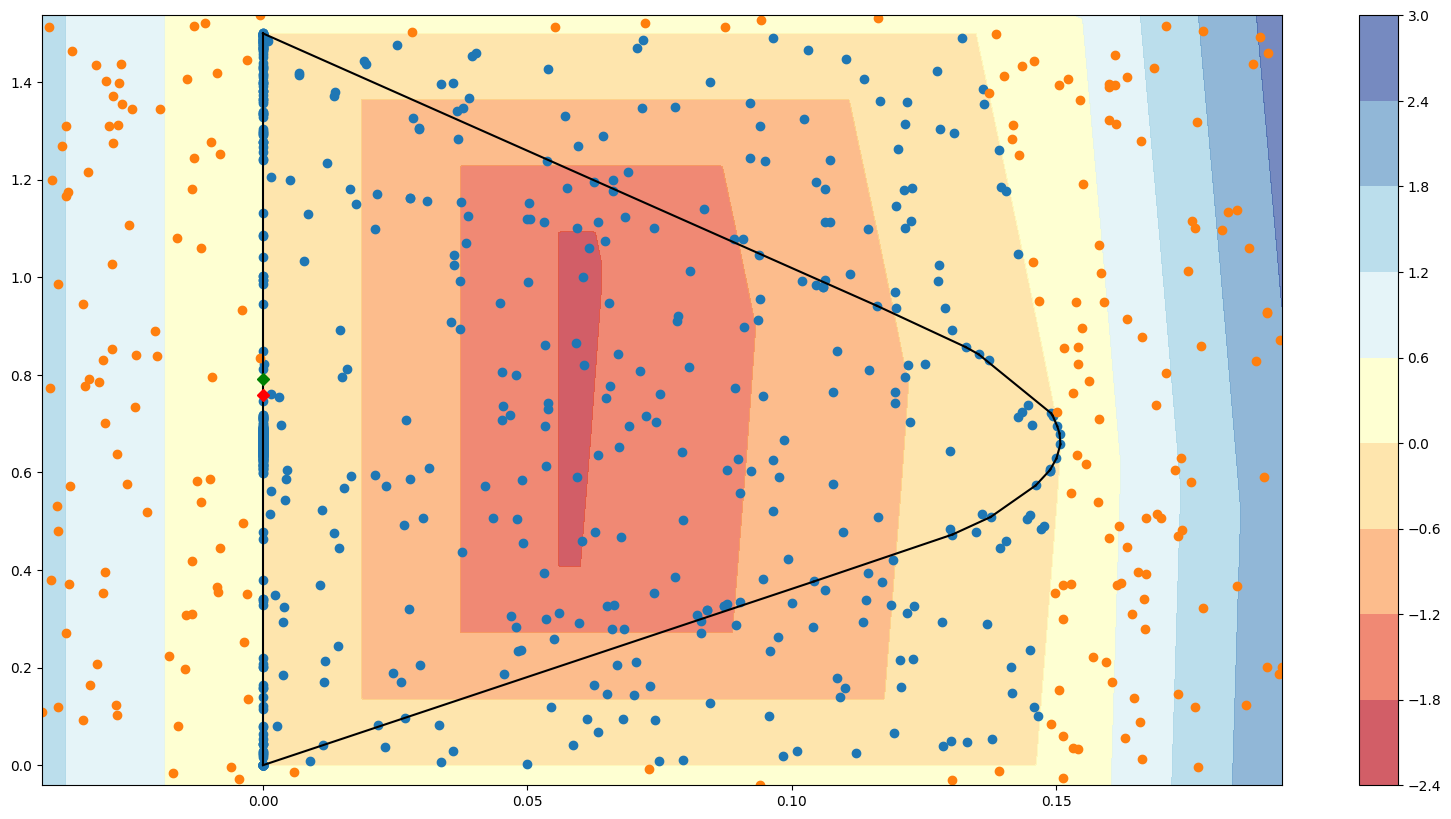

Current layer 0, current group tensor([33, 42])


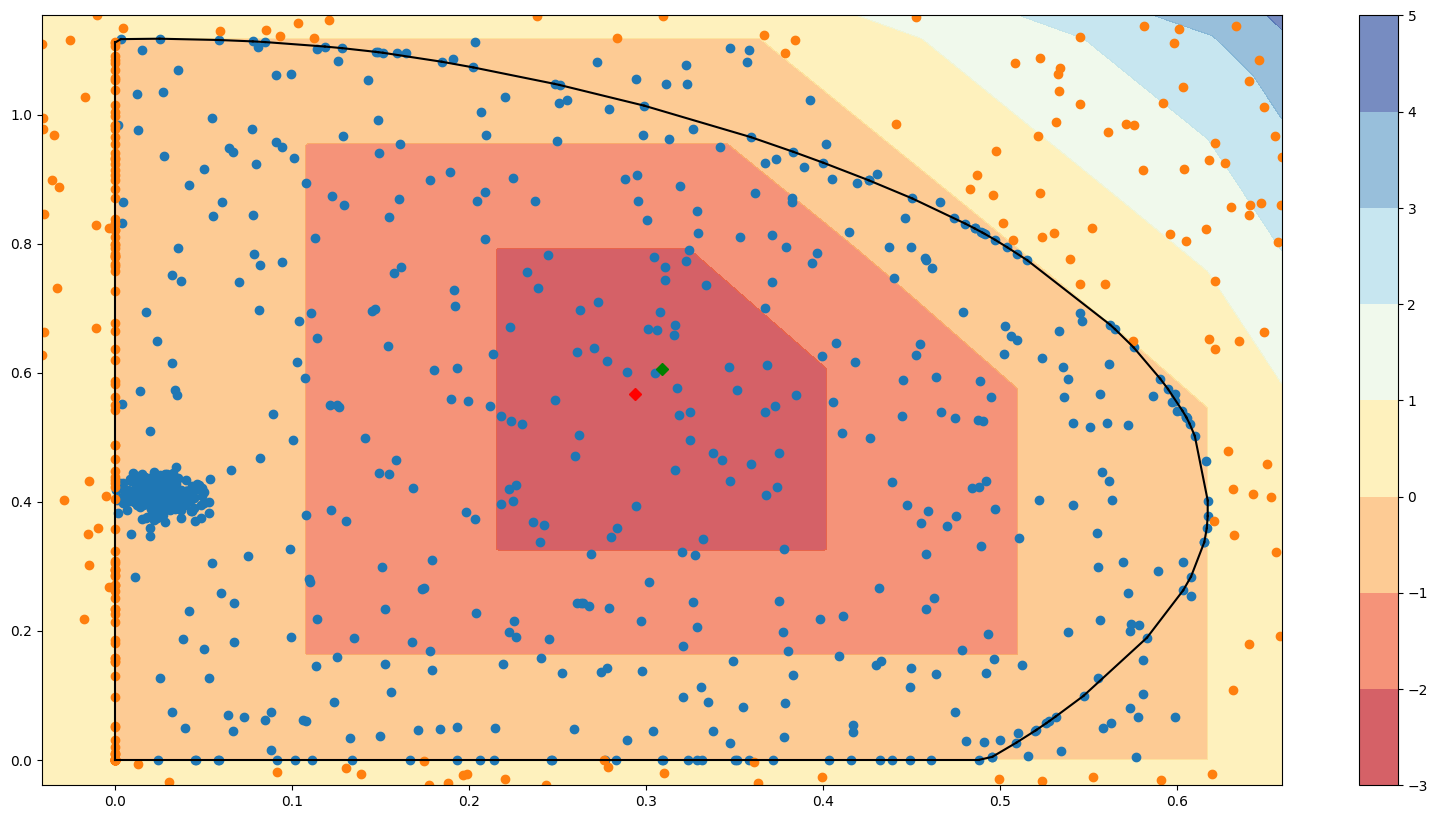

Current layer 0, current group tensor([45, 51])


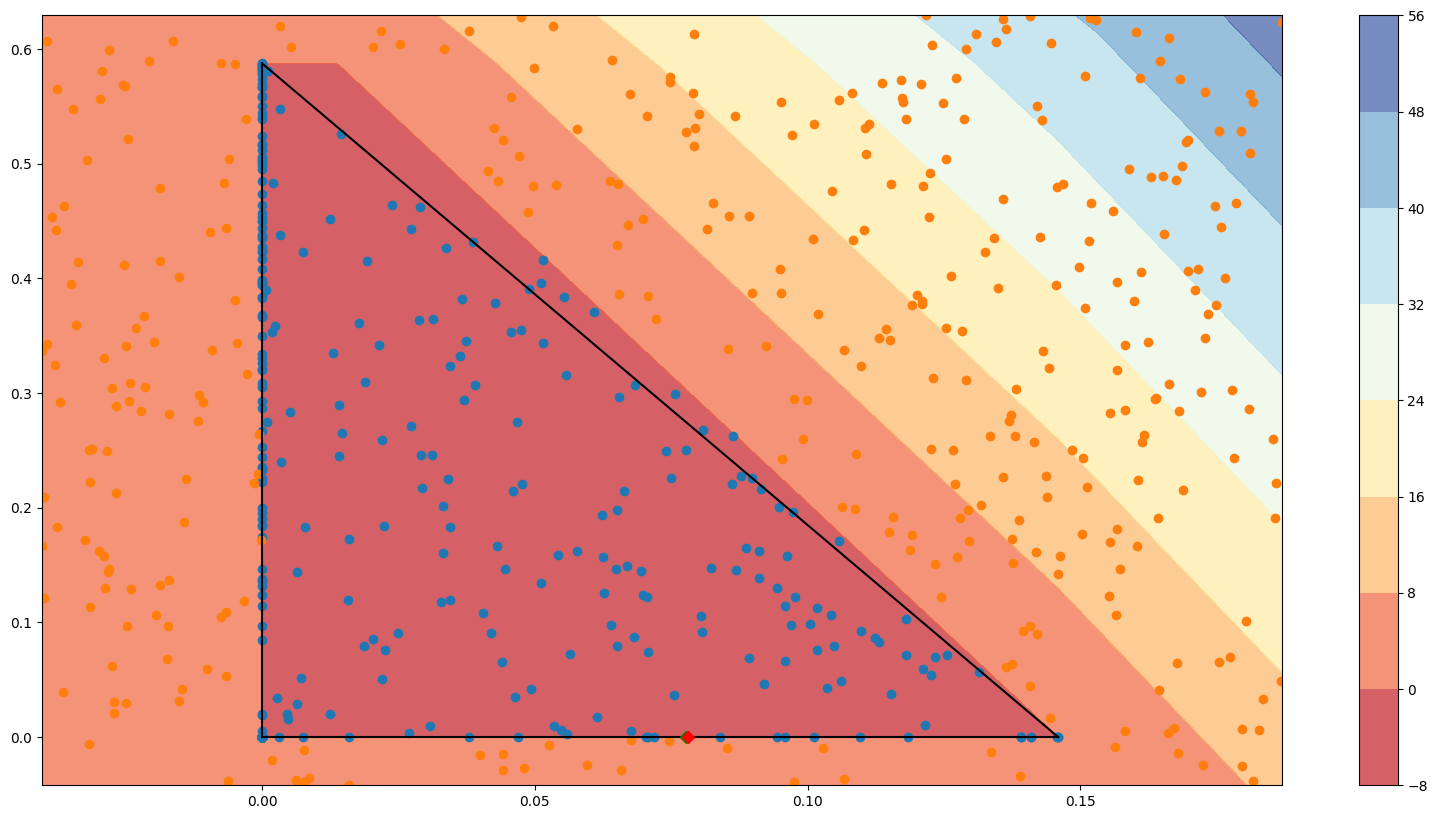

Current layer 0, current group tensor([55, 57])


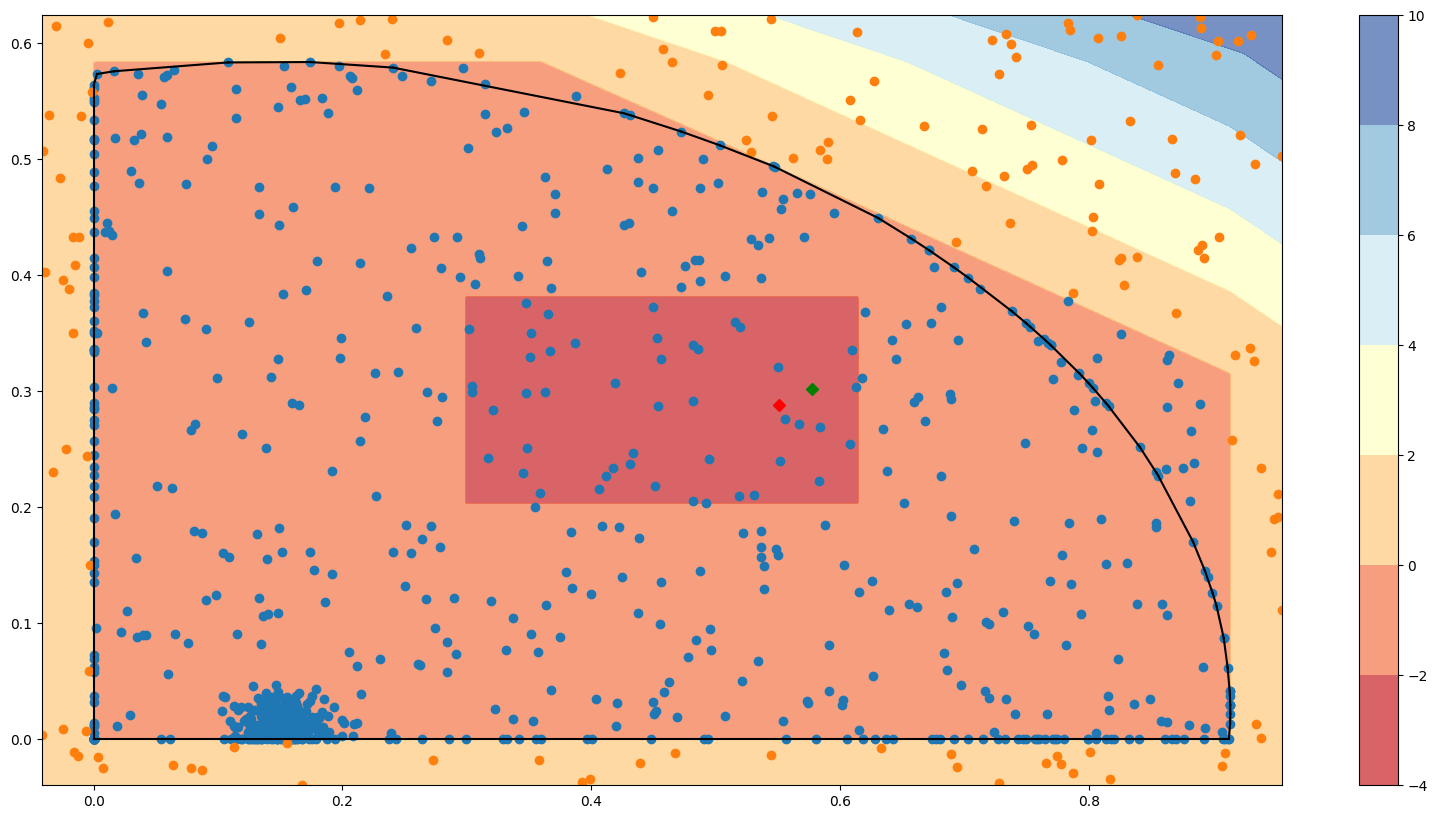

Current layer 0, current group tensor([58, 59])


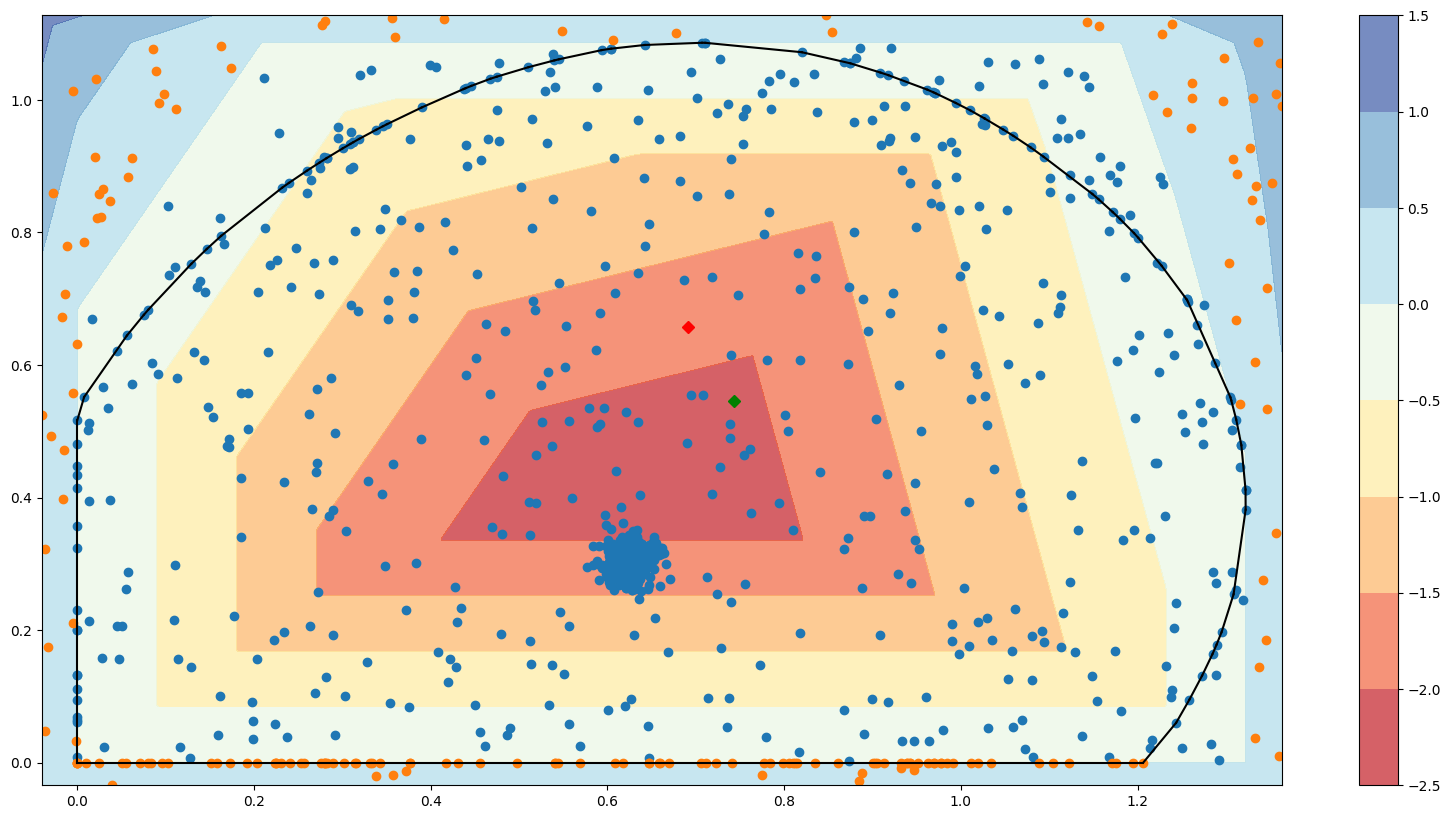

Current layer 0, current group tensor([60, 65])


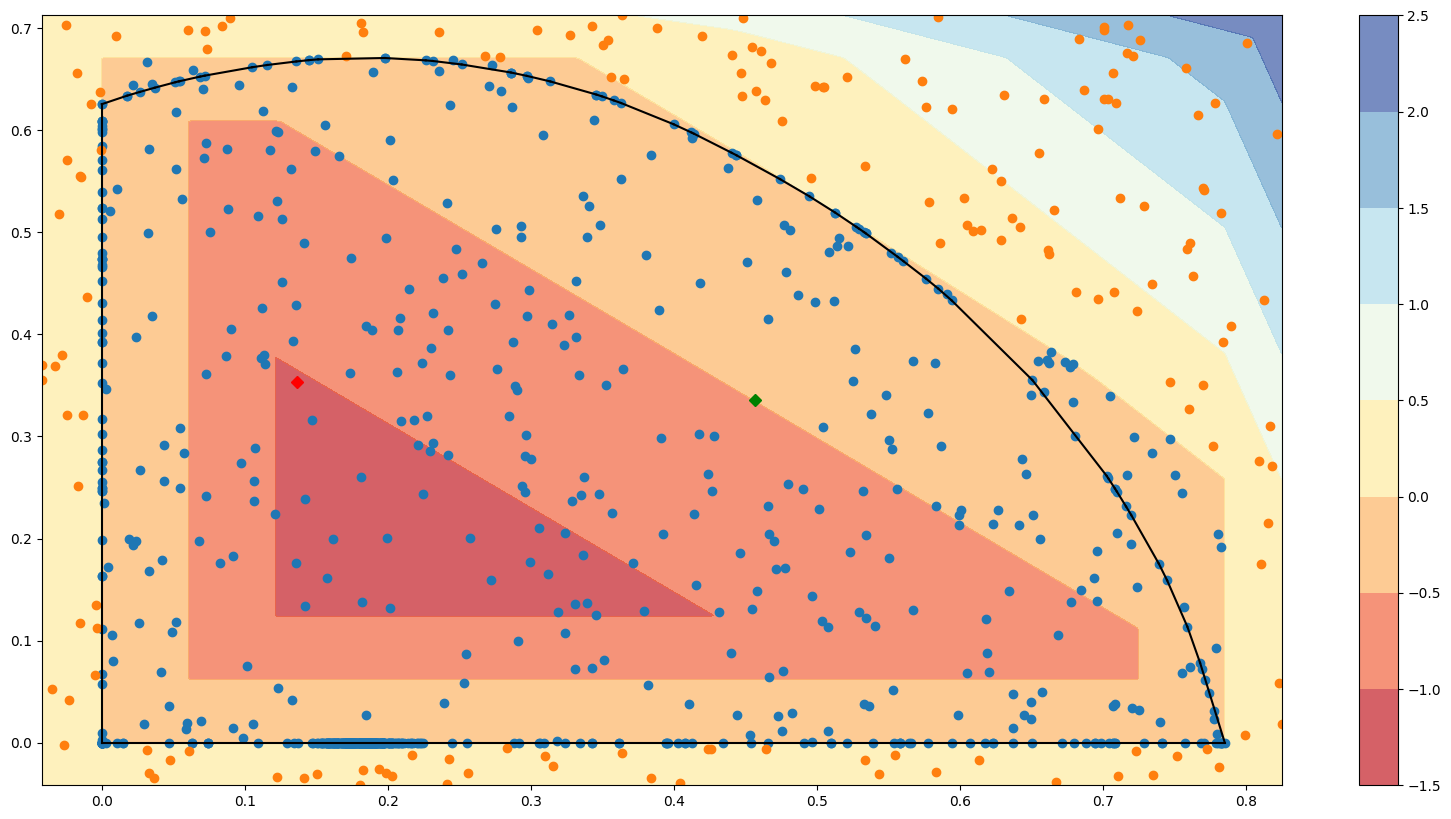

Current layer 0, current group tensor([66, 67])


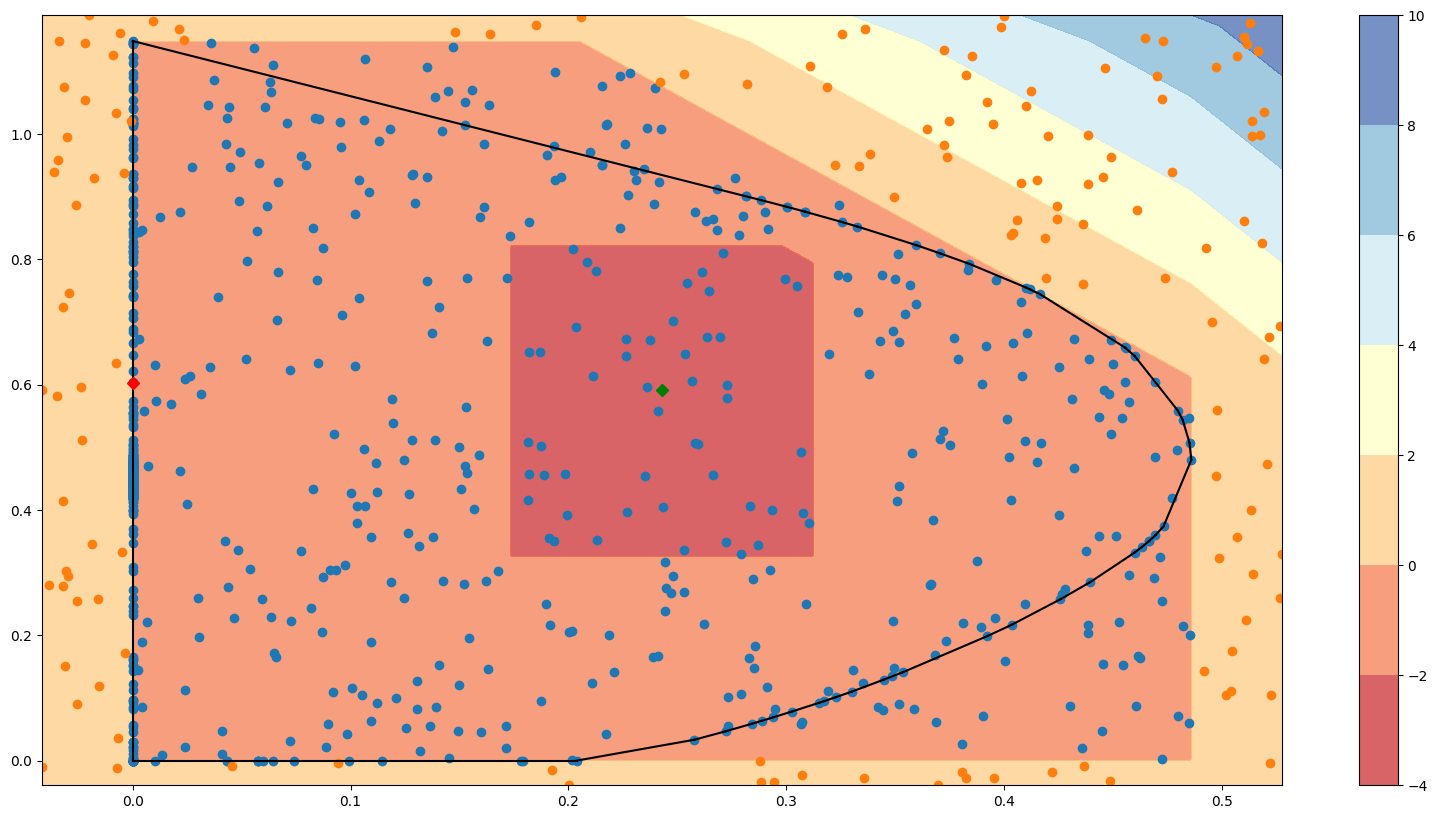

Current layer 0, current group tensor([77, 78])


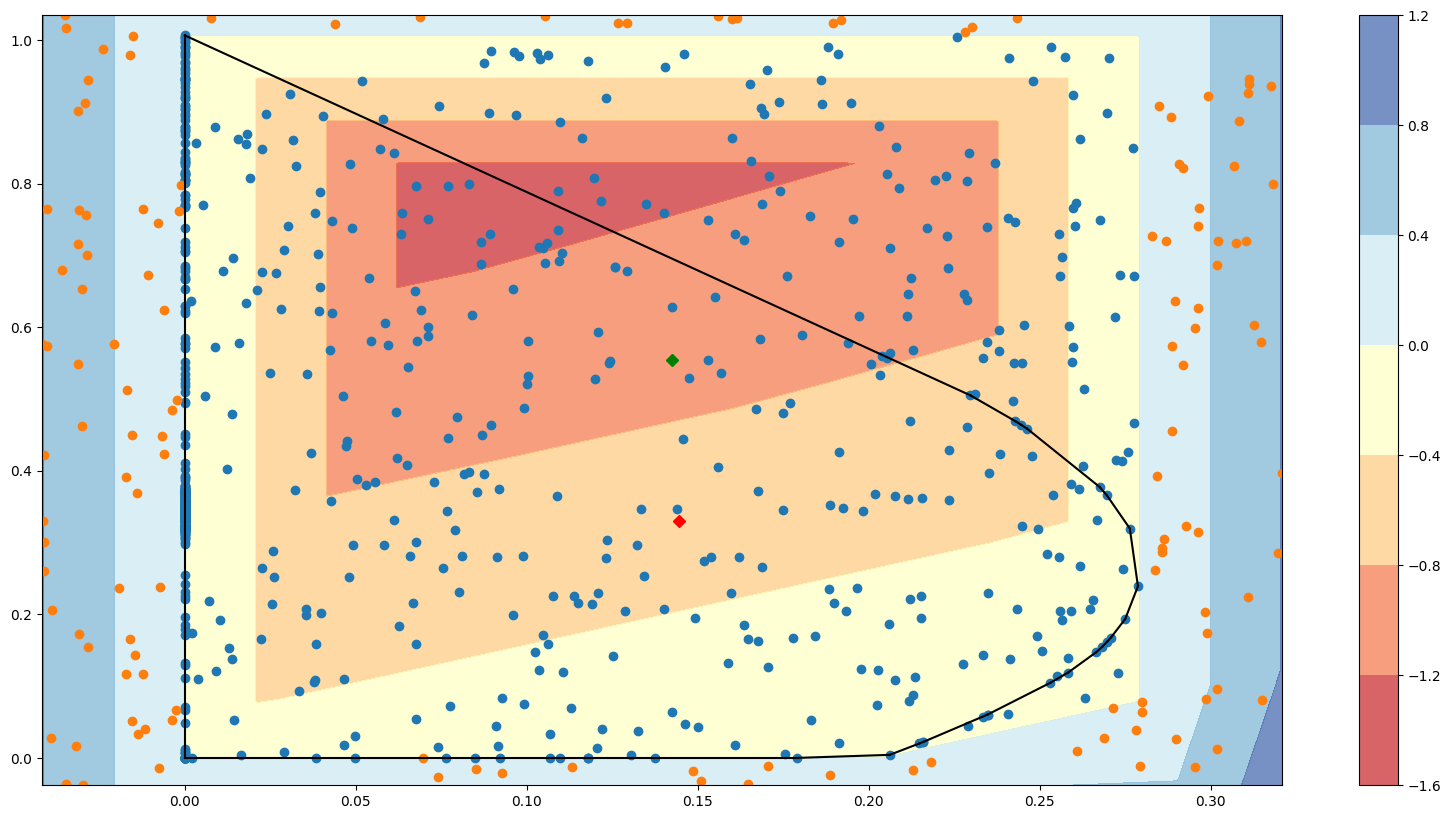

Current layer 0, current group tensor([80, 81])


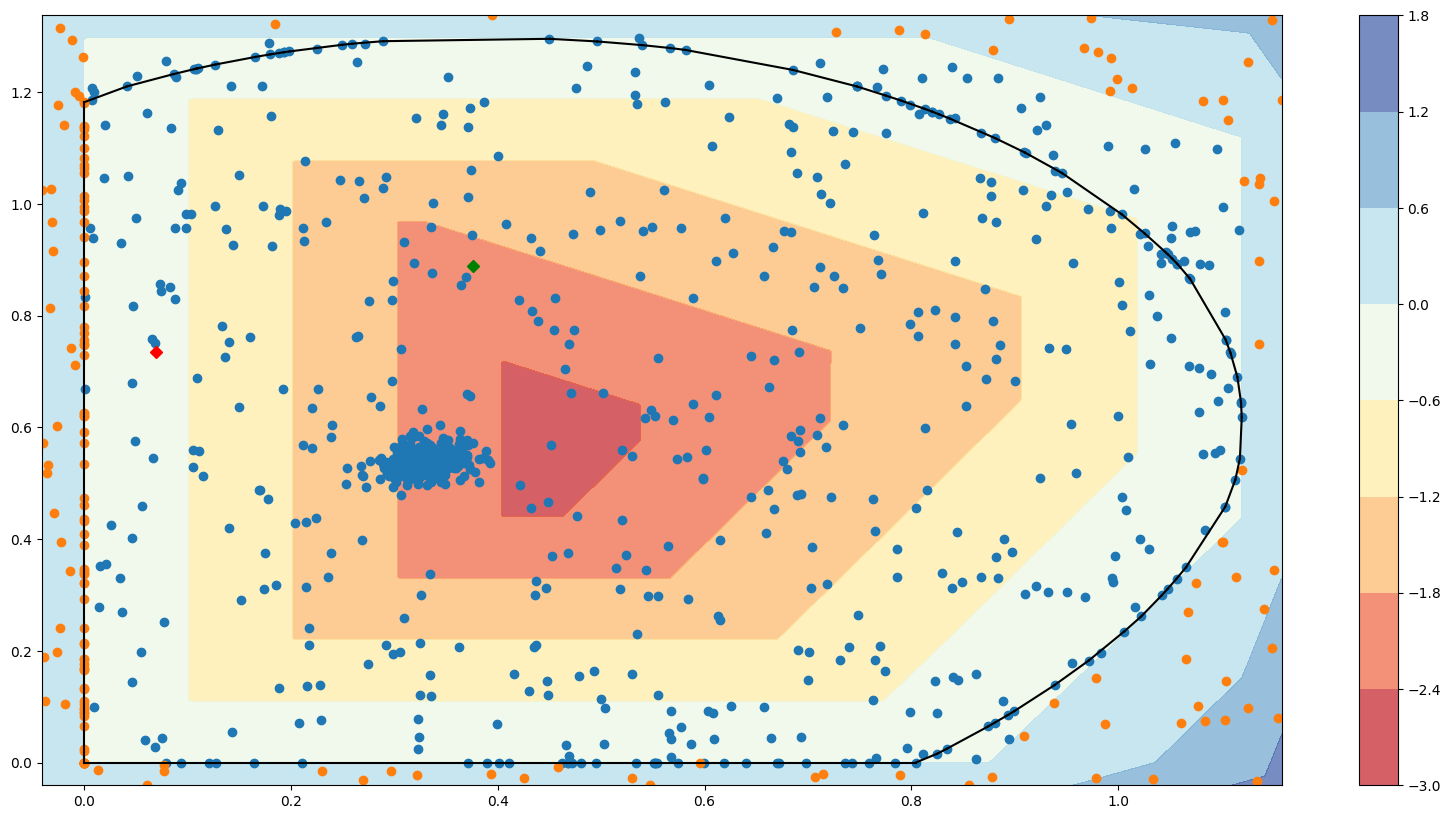

Current layer 0, current group tensor([82, 85])


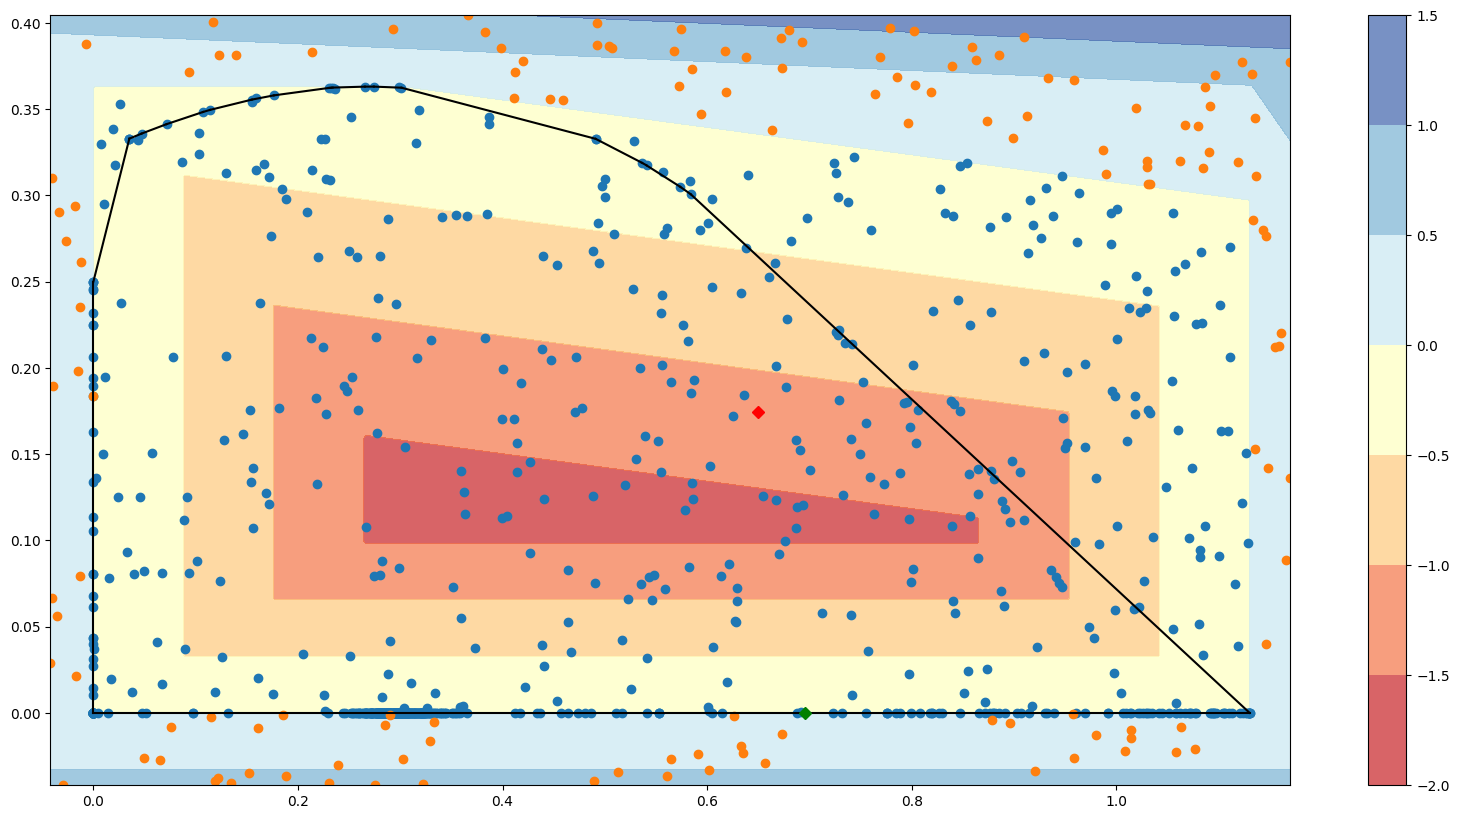

Current layer 0, current group tensor([91, 93])


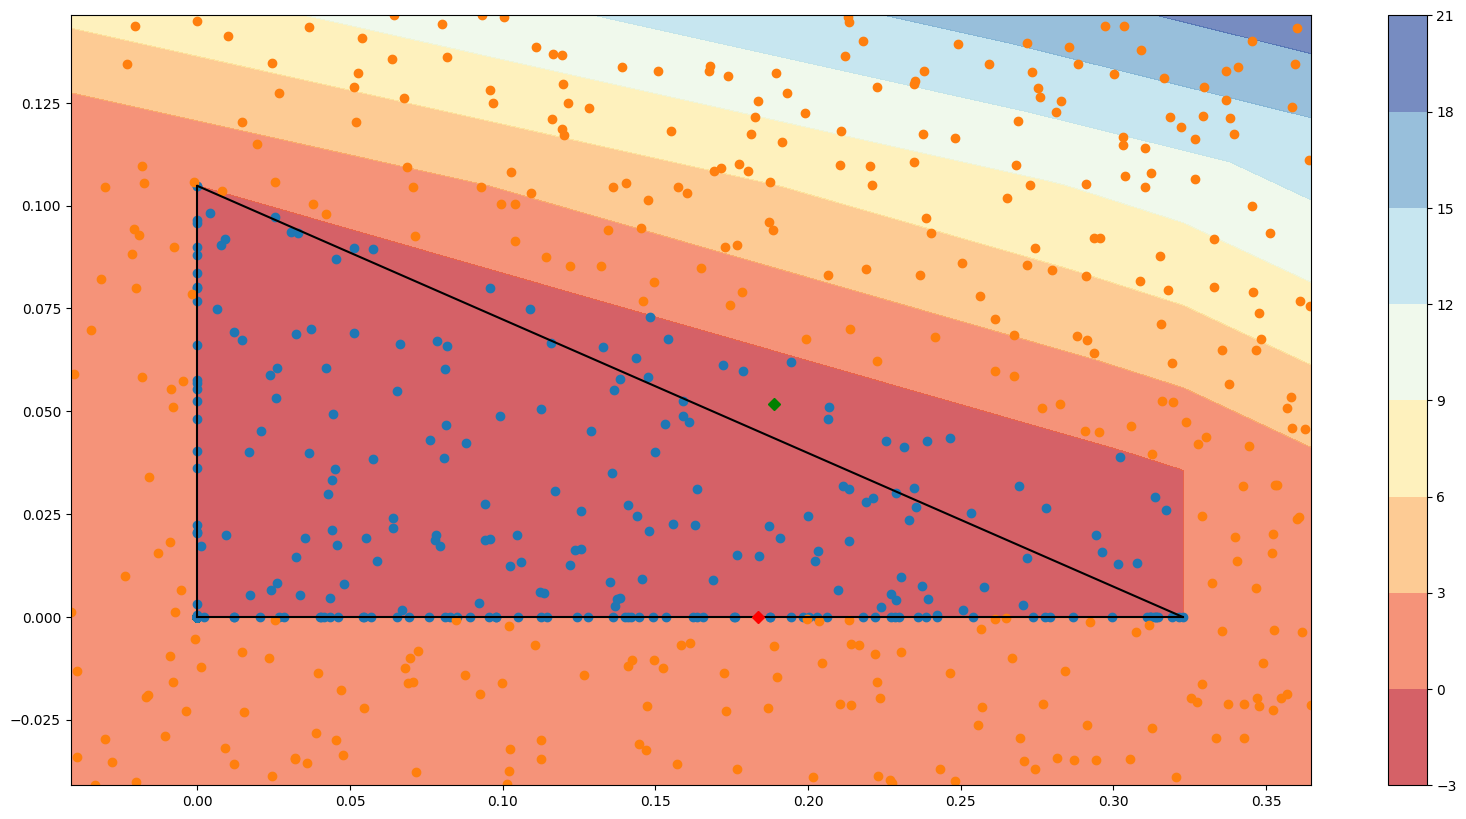

Current layer 0, current group tensor([94, 95])


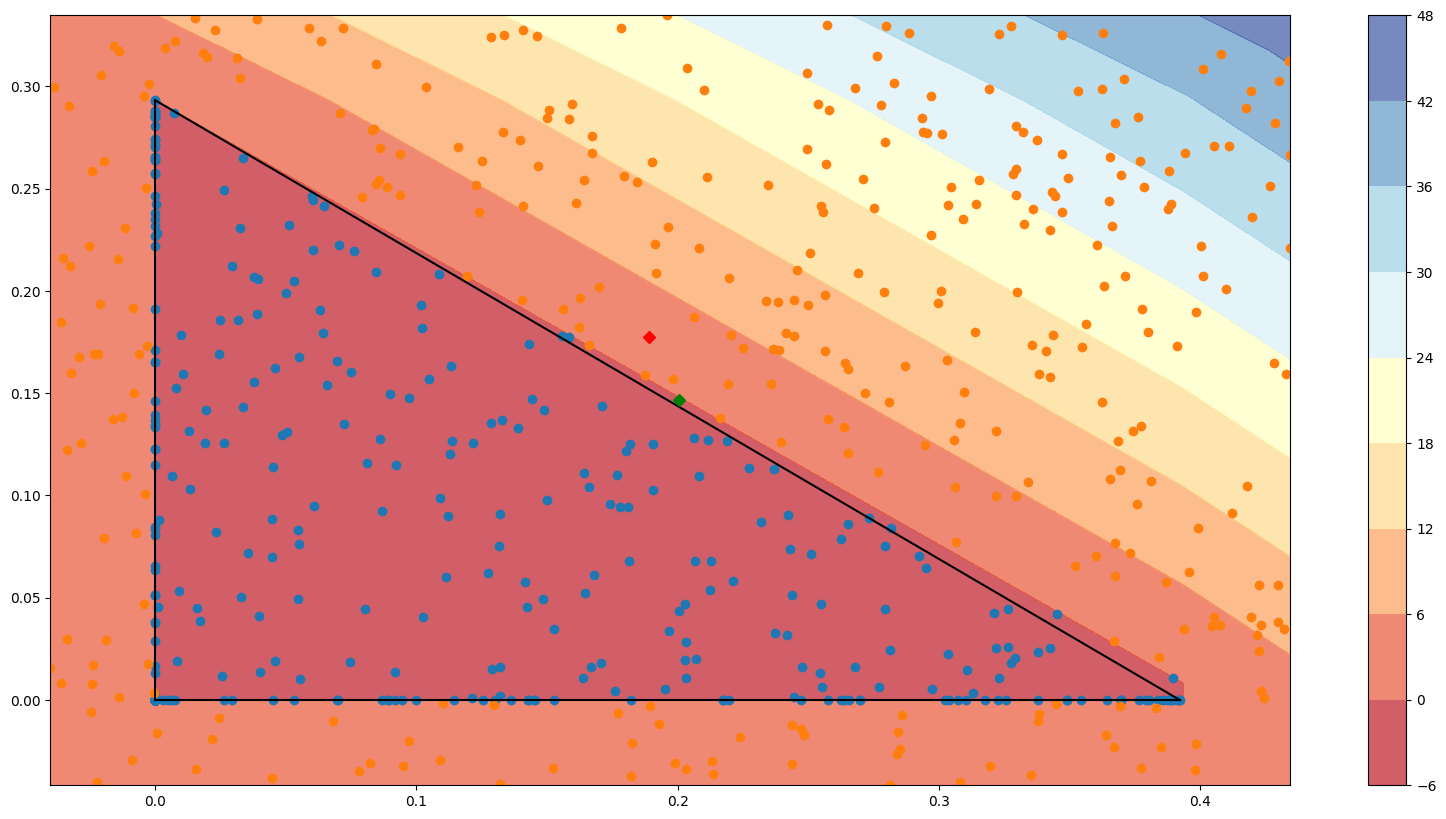

Current layer 0, current group tensor([96, 97])


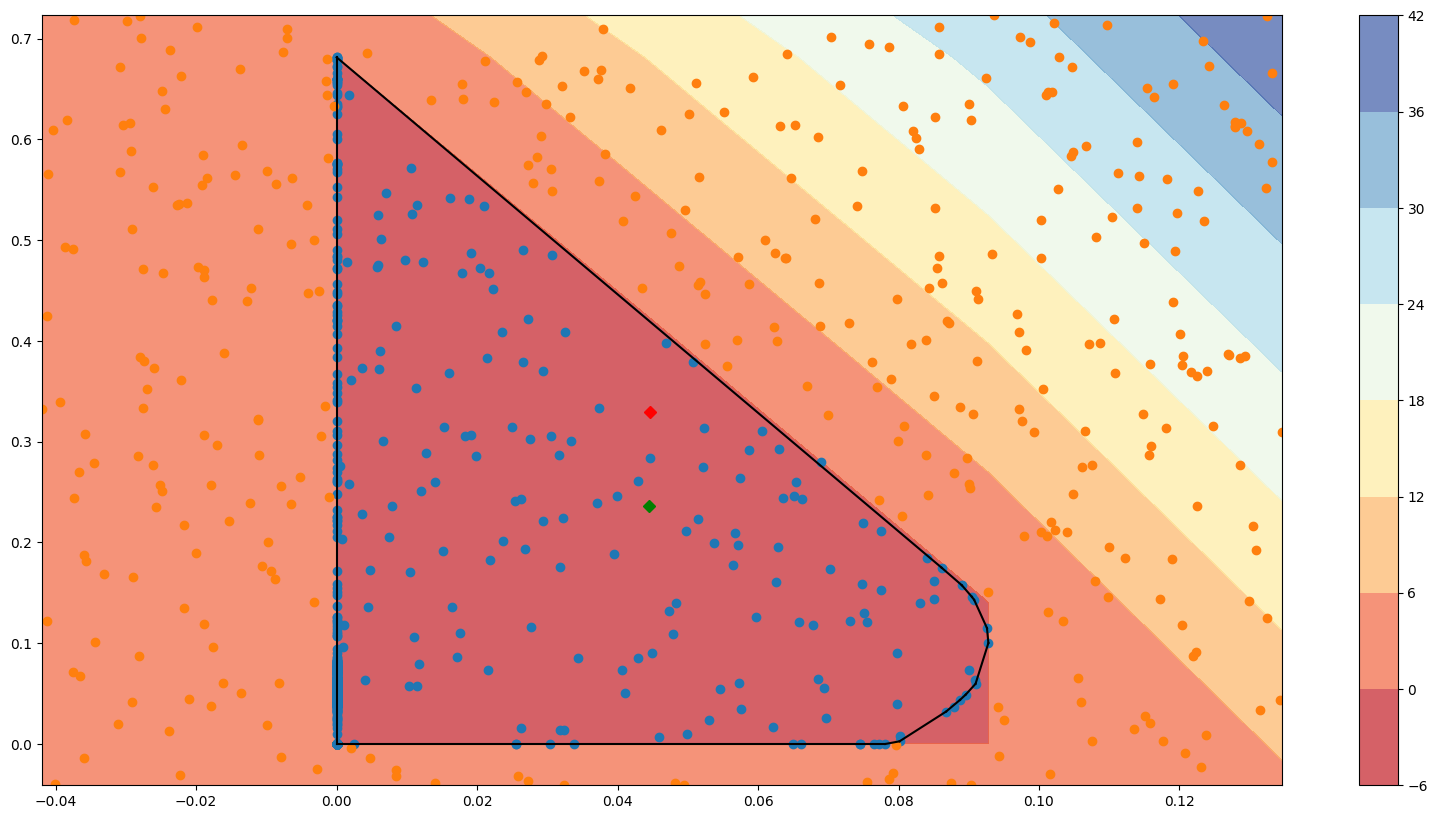

Current layer 0, current group tensor([98, 99])


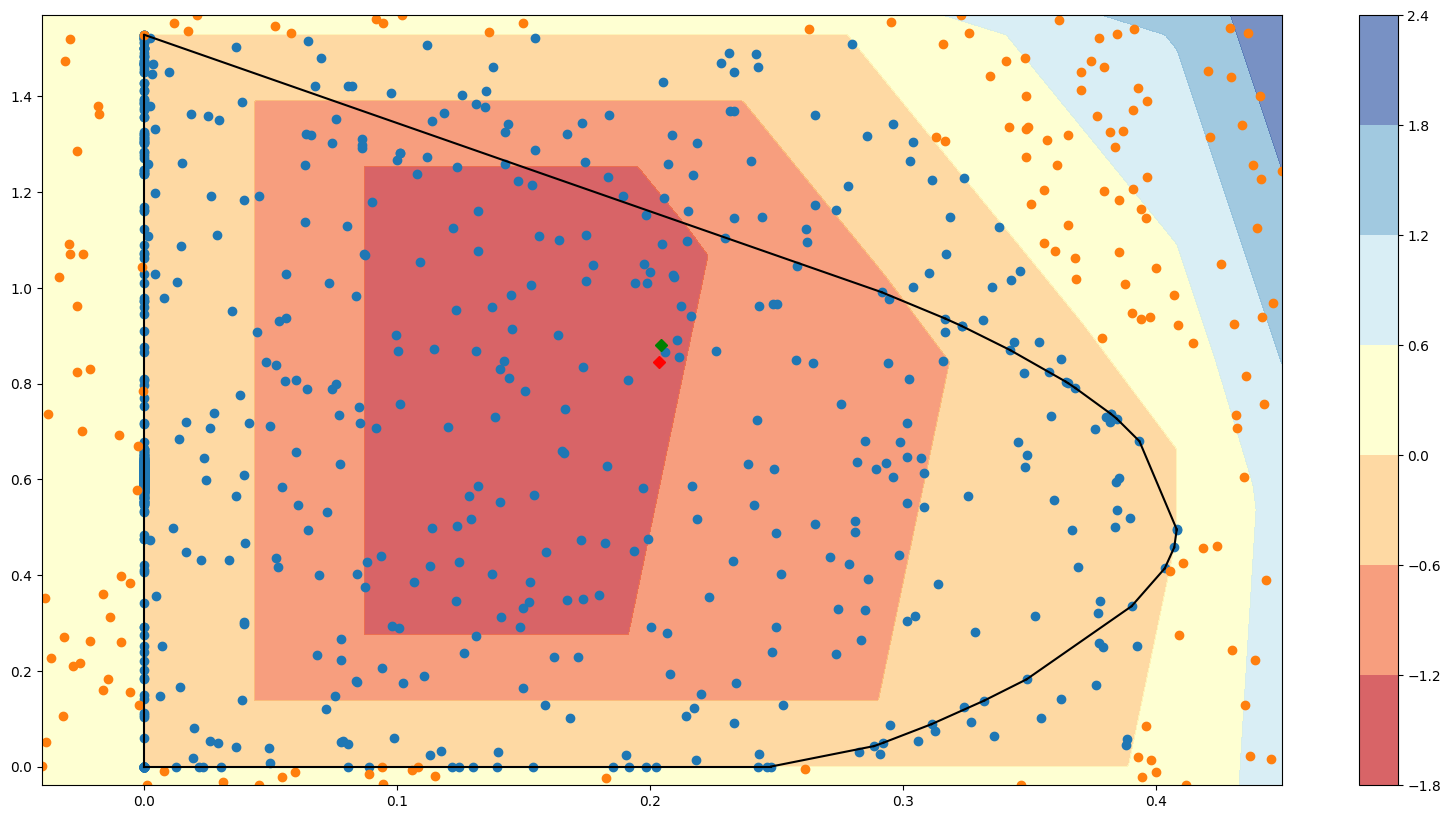

Current layer 1, current group tensor([0, 1])


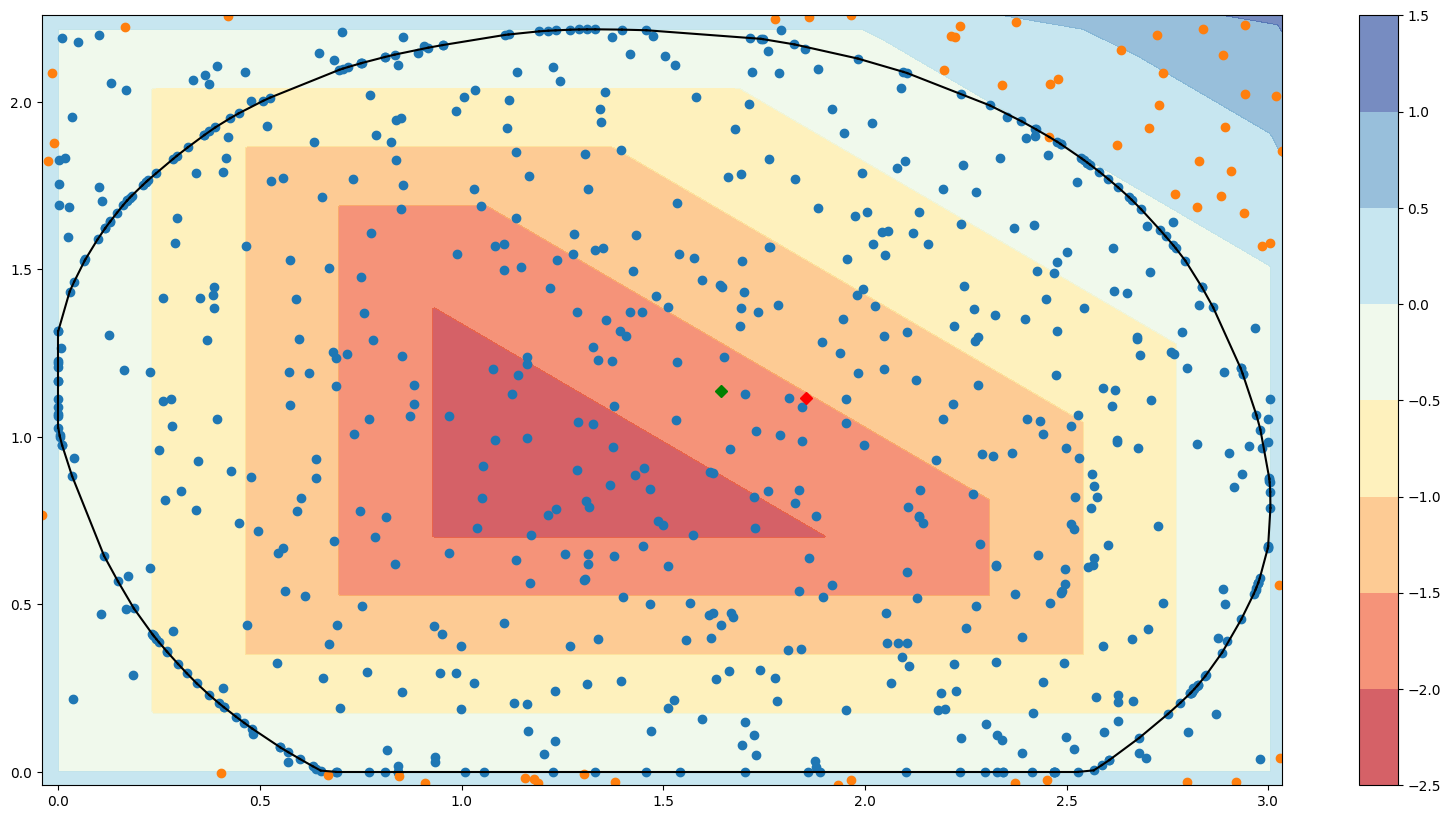

Current layer 1, current group tensor([3, 4])


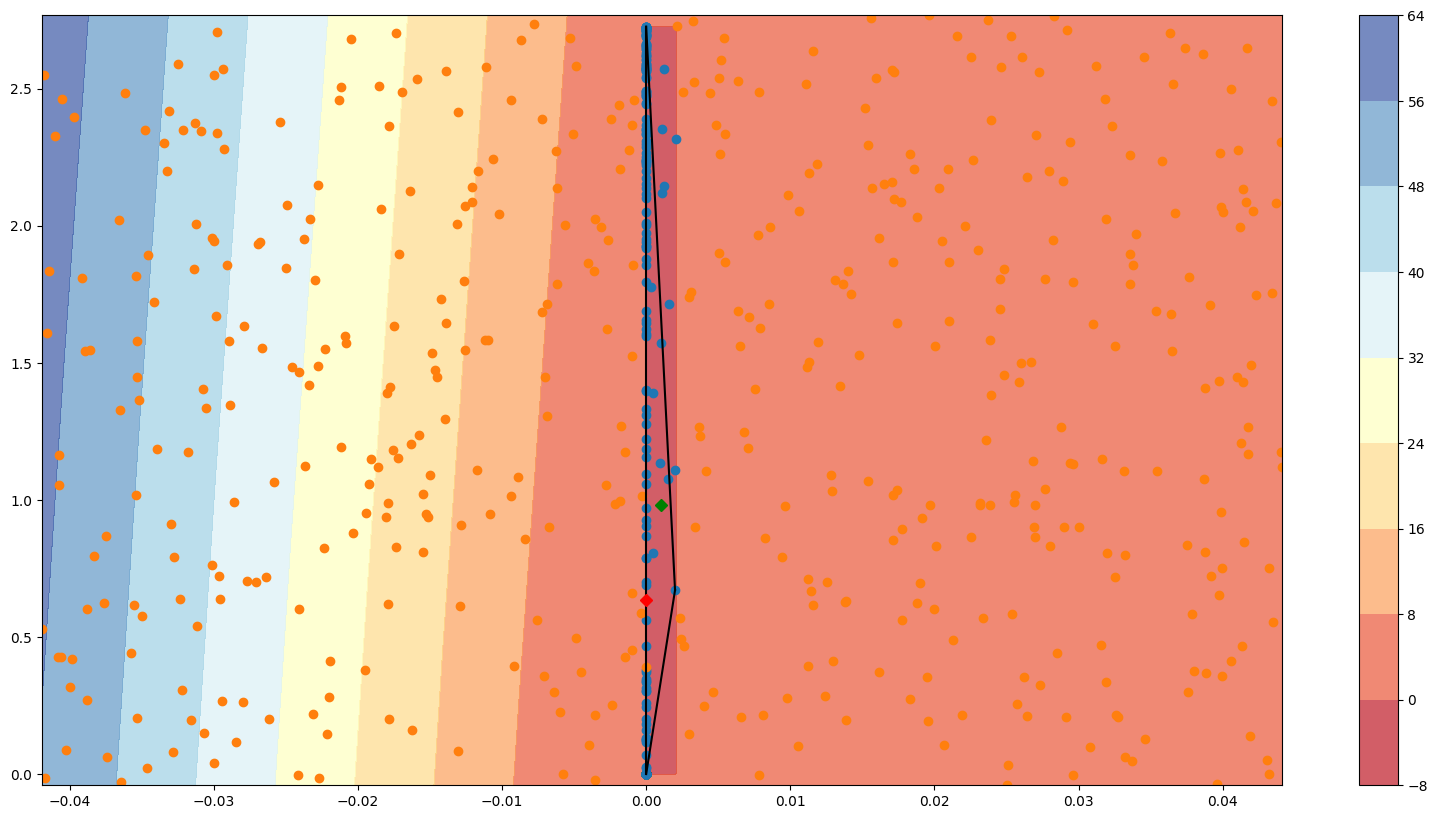

Current layer 1, current group tensor([7, 8])


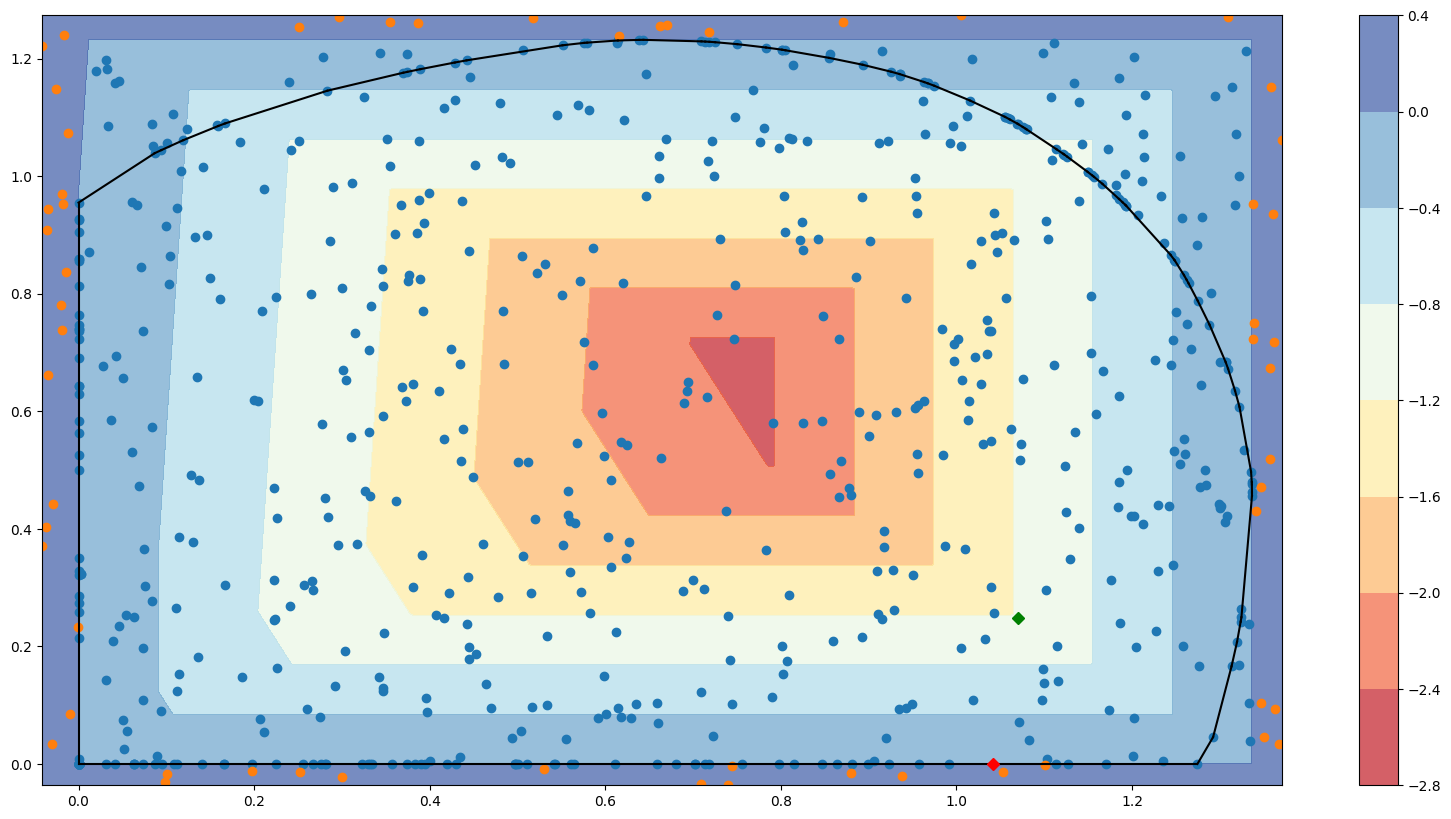

Current layer 1, current group tensor([10, 21])


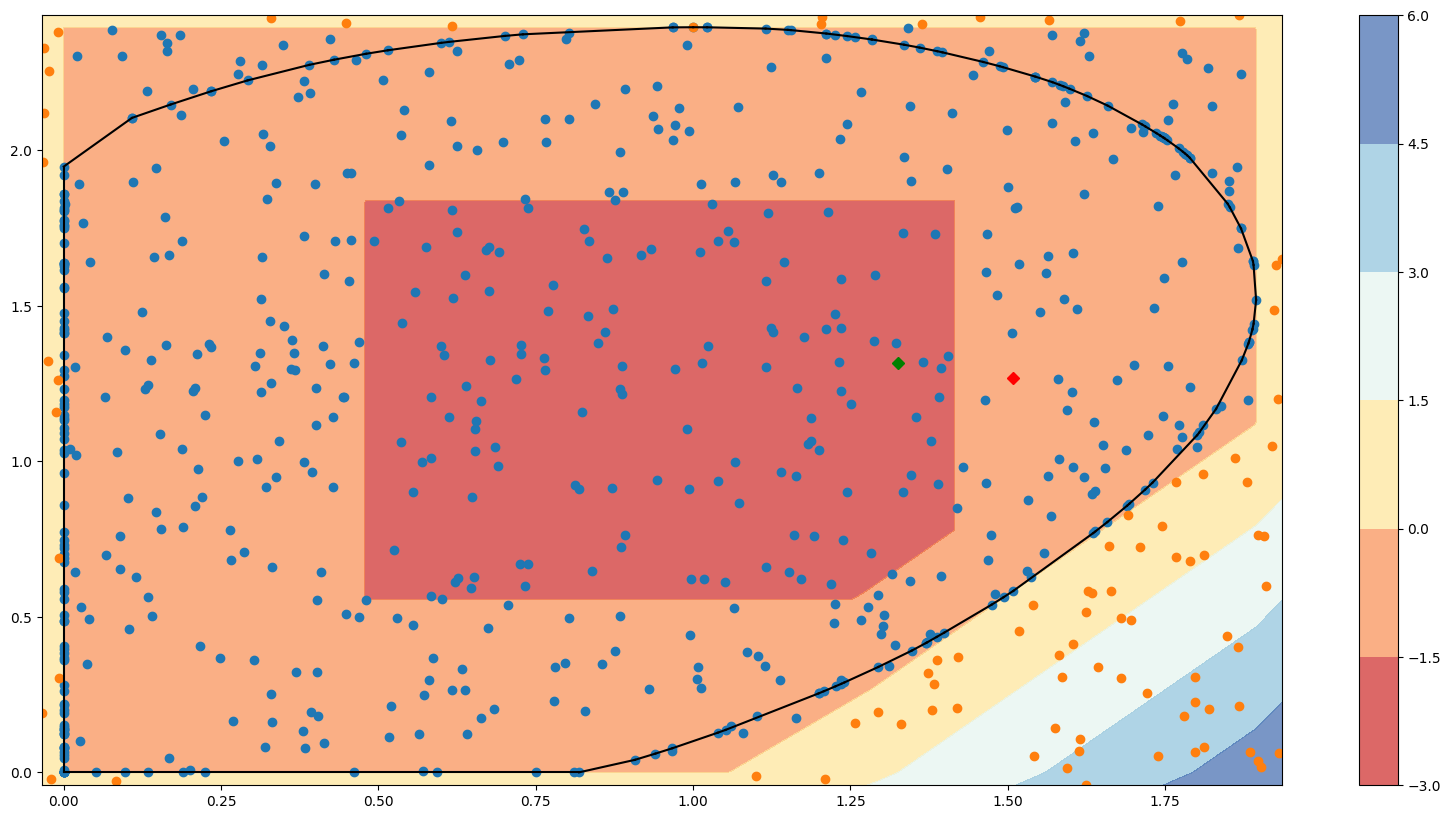

Current layer 1, current group tensor([22, 25])


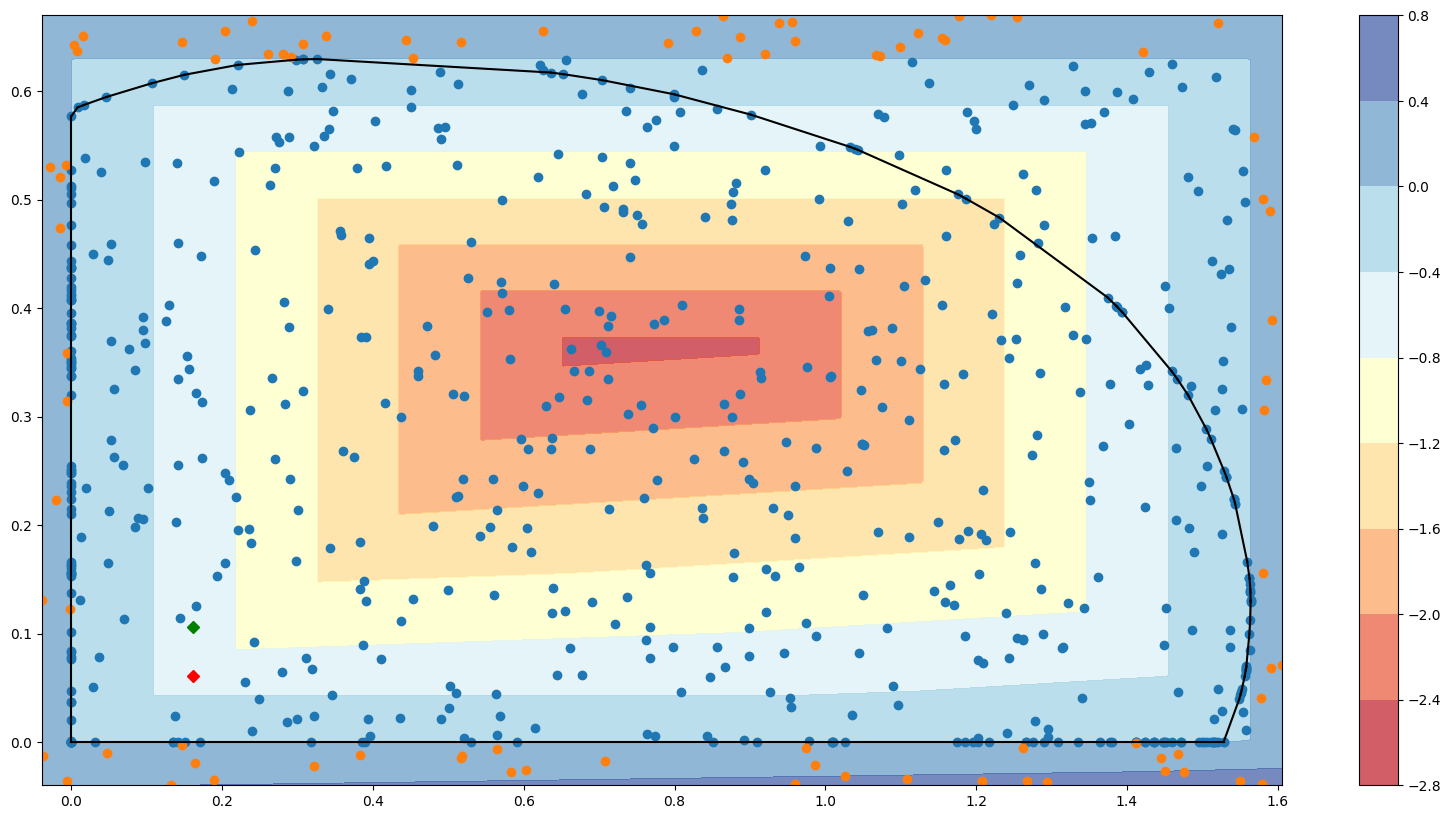

Current layer 1, current group tensor([28, 29])


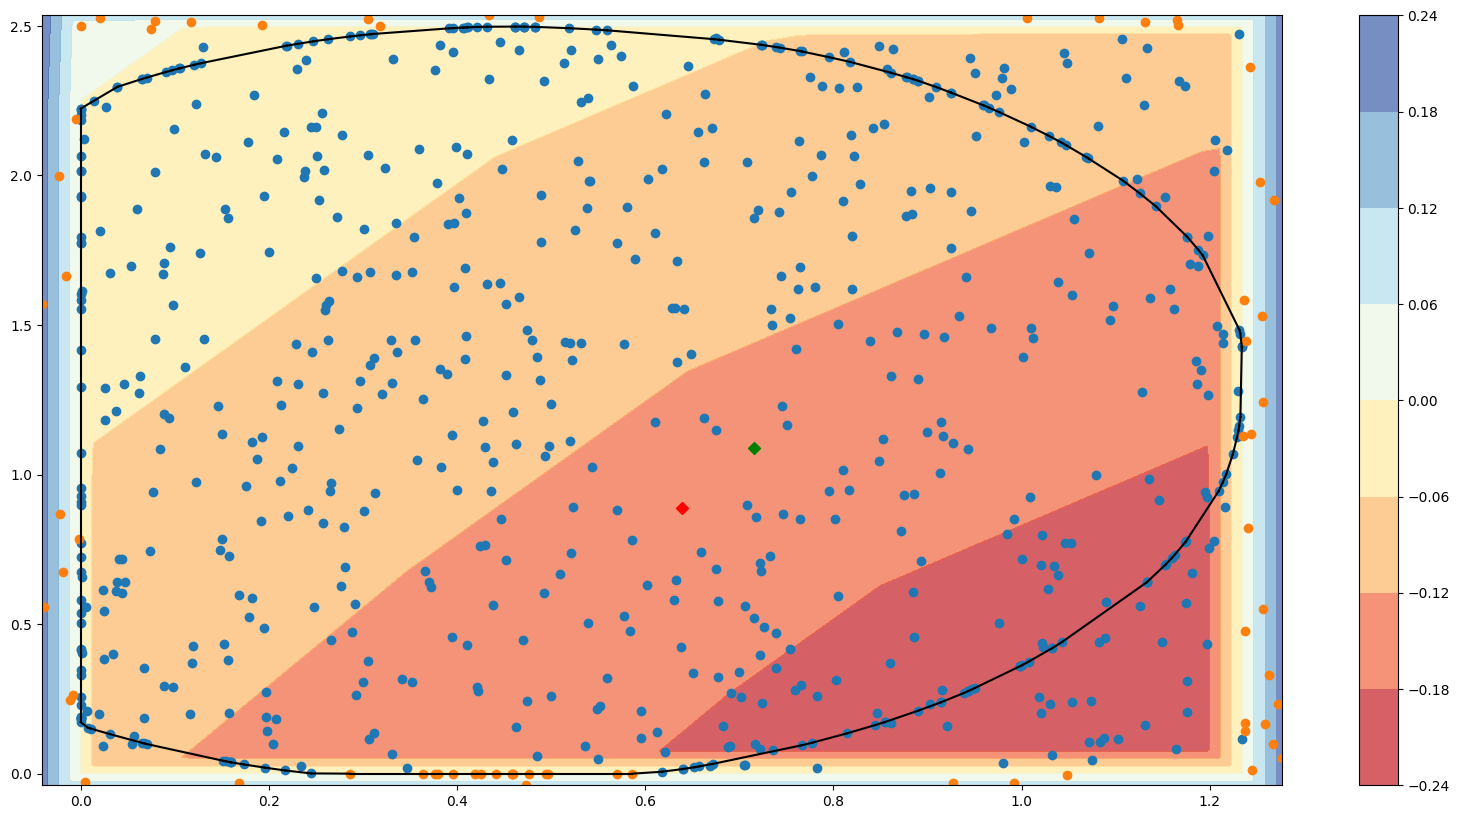

In [21]:
for layer_index, icnn_per_layer in enumerate(dhov_verifier.list_of_icnns):
    for group_index, current_icnn in enumerate(icnn_per_layer):
        current_group = torch.tensor(dhov_verifier.all_group_indices[layer_index][group_index], dtype=torch.int64)
        print("Current layer {}, current group {}".format(layer_index, current_group))
        if len(current_group) != 2:
            continue
        group_inc_space = torch.index_select(dhov_verifier.list_of_included_samples[layer_index][group_index], 1, current_group)
        group_amb_space = torch.index_select(dhov_verifier.list_of_ambient_samples[layer_index][group_index], 1, current_group)
        min_x, max_x, min_y, max_y = multidhov.get_min_max_x_y(torch.cat([group_inc_space.detach(), group_amb_space.detach()]))
        plots = eval.Plots_for(0, current_icnn, group_inc_space.detach(), group_amb_space.detach(),
                          [min_x, max_x], [min_y, max_y])
        optimized_x = dhov_model.getVarByName("output_layer_[{}]_[{}]".format(layer_index, current_group[0])).getAttr("x")
        optimized_y = dhov_model.getVarByName("output_layer_[{}]_[{}]".format(layer_index, current_group[1])).getAttr("x")
        plt.style.use("default")
        plots.plt_mesh(show=False)
        plt.plot(optimized_x, optimized_y, "Dg")

        if layer_index != 2:
            optimized_x = snv_model.getVarByName("relu_var{}[{}]".format(2*layer_index, current_group[0])).getAttr("x")
            optimized_y = snv_model.getVarByName("relu_var{}[{}]".format(2*layer_index, current_group[1])).getAttr("x")
        else:
            optimized_x = snv_model.getVarByName("last_affine_var[{}]".format(current_group[0])).getAttr("x")
            optimized_y = snv_model.getVarByName("last_affine_var[{}]".format(current_group[1])).getAttr("x")

        plt.plot(optimized_x, optimized_y, "Dr")

        plt.show()
